# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


<h1>1. GBDT (xgboost/lightgbm) </h1>

In [2]:
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=e592b0dc29d617c50e026046d7ad30dee37ff655d2b25428f5b05fbace057288
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re

import pickle
from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from scipy.sparse import hstack

Output hidden; open in https://colab.research.google.com to view.

## 1.1 Loading Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
processed_data = pd.read_csv('drive/My Drive/AI_ML Course/AAC Course Assignments/Assignment-13/preprocessed_data.csv') 
resource_data = pd.read_csv('drive/My Drive/AI_ML Course/AAC Course Assignments/Assignment-13/resources.csv')

In [31]:
processed_data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [32]:
print("The attributes of processed data :", processed_data.columns.values)
print("*"*100)
print("The attributes of resource data :", resource_data.columns.values)

The attributes of processed data : ['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price']
****************************************************************************************************
The attributes of resource data : ['id' 'description' 'quantity' 'price']


In [33]:
print("Number of data points in processed data", processed_data.shape)
print("Number of data points in resource data", resource_data.shape)


Number of data points in processed data (109248, 9)
Number of data points in resource data (1541272, 4)


In [34]:
train_data = pd.read_csv('drive/My Drive/AI_ML Course/AAC Course Assignments/Assignment-13/train_data.csv') 
train_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0


In [35]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [36]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [37]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [38]:
preprocessed_titles = preprocess_text(train_data['project_title'].values)

100%|██████████| 109248/109248 [00:02<00:00, 40757.50it/s]


In [39]:
processed_data["project_title"] = preprocessed_titles
processed_data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,project_title
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,educational support english learners home


In [40]:
print("printing some random reviews")
print(34, processed_data['project_title'].values[34])
print(64, processed_data['project_title'].values[64])
print(252, processed_data['project_title'].values[252])

printing some random reviews
34 ball
64 read art
252 robotics future interactive minds create


In [41]:
#Finding unique value counts in project_grade_category column
processed_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

In [42]:
#Finding unique value counts in clean_categories column
processed_data['clean_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language specialneeds           3961
appliedlearning                          3771
math_science literacy_language           2289
appliedlearning literacy_language        2191
history_civics                           1851
math_science specialneeds                1840
literacy_language music_arts             1757
math_science music_arts                  1642
appliedlearning specialneeds             1467
history_civics literacy_language         1421
health_sports specialneeds               1391
warmth care_hunger                       1309
math_science appliedlearning             1220
appliedlearning math_science             1052
literacy_language history_civics          809
health_sports literacy_language   

In [43]:
#Finding unique value counts in teacher_prefix column
processed_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

In [44]:
#Finding unique value counts in clean_subcategories column
processed_data['clean_subcategories'].value_counts()

literacy                                 9486
literacy mathematics                     8325
literature_writing mathematics           5923
literacy literature_writing              5571
mathematics                              5379
                                         ... 
economics nutritioneducation                1
communityservice music                      1
history_geography warmth care_hunger        1
communityservice gym_fitness                1
college_careerprep warmth care_hunger       1
Name: clean_subcategories, Length: 401, dtype: int64

In [45]:
#Finding unique value counts in school_state column
processed_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

In [46]:
print("printing some random essay")
print(10, processed_data['essay'].values[10])
print('-'*50)
print(42, processed_data['essay'].values[42])
print('-'*50)
print(160, processed_data['essay'].values[160])

printing some random essay
10 my students yearn classroom environment matches desire learn with education changing daily need classroom meet needs first graders i privilege teaching incredible group six seven year olds absolutely love learn i completely blown away love learning each day new adventure enjoy learning nonfiction text hands activities many students active learners benefit kinesthetic activities sometimes learning sitting seat difficult i want every child opportunity focus energy order best school ideally i would love delve right flexible seating students provided many different seating options chairs hokki stools mats ground etc freedom choose ever seat feel need my student would able choose seating option best help learn in addition pencil sharpener mobile easel magnetic strips mounting tape help make classroom better suited 6 7 year olds this project beneficial students able better focus energy something small choosing seat help encourage positive learning environment pr

**Sentiment Analysis and adding positive/neg/neutral/compound to the data matrix**

In [47]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia  = SentimentIntensityAnalyzer()

negative_sentiments = []
positive_sentiments = []
neutral_sentiments = []
compound_sentiments = []

for i in tqdm(processed_data['essay']):
  sia_sentiments = sia.polarity_scores(i)
  negative_sentiments.append(sia_sentiments['neg'])
  positive_sentiments.append(sia_sentiments['pos'])
  neutral_sentiments.append(sia_sentiments['neu'])
  compound_sentiments.append(sia_sentiments['compound'])
  
# Now append these sentiments columns/freatures to original preprocessed dataframe
processed_data['negative_sent'] = negative_sentiments
processed_data['positive_sent'] = positive_sentiments
processed_data['neutral_sent'] = neutral_sentiments
processed_data['compound_sent'] = compound_sentiments

processed_data.head(1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 109248/109248 [03:05<00:00, 588.63it/s]


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,project_title,negative_sent,positive_sent,neutral_sent,compound_sent
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,educational support english learners home,0.013,0.205,0.783,0.9867


In [48]:
processed_data.columns  

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'project_title', 'negative_sent', 'positive_sent', 'neutral_sent',
       'compound_sent'],
      dtype='object')

In [49]:
processed_data.shape

(109248, 14)

In [50]:
processed_data = processed_data.sample(frac=0.35)
processed_data.shape

(38237, 14)

In [51]:
processed_data.isnull().sum()

school_state                                    0
teacher_prefix                                  0
project_grade_category                          0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
clean_categories                                0
clean_subcategories                             0
essay                                           0
price                                           0
project_title                                   0
negative_sent                                   0
positive_sent                                   0
neutral_sent                                    0
compound_sent                                   0
dtype: int64

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [52]:
# Splitting data
y = processed_data['project_is_approved'].values
processed_data.drop(['project_is_approved'], axis=1, inplace=True)
X = processed_data
processed_data.shape

(38237, 13)

In [53]:
X.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'project_title',
       'negative_sent', 'positive_sent', 'neutral_sent', 'compound_sent'],
      dtype='object')

In [54]:
# Split Train, CV and Test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('Train Data Set', X_train.shape, y_train.shape)
print('Test Data Set', X_test.shape, y_test.shape)

Train Data Set (26765, 13) (26765,)
Test Data Set (11472, 13) (11472,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

**TFIDF-for Essay column**

In [55]:
# As required for Task-1, applying TFIDF on the Essay column
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)

# Apply .fit() on this vectorizer on Train data
# Note .fit() is applied only on the train data, as test and cv should not be fitted
vectorizer_essay_tfidf.fit(X_train['essay'].values)

# Now use the fitted TfidfVectorizer for converting 'essay' text to Vector form
X_train_vectorized_tfidf_essay = vectorizer_essay_tfidf.transform(X_train['essay'].values)
X_test_vectorized_tfidf_essay = vectorizer_essay_tfidf.transform(X_test['essay'].values)

print('After TFIDF on Essay column checking the shapes')
print(X_train_vectorized_tfidf_essay.shape, y_train.shape)
print(X_test_vectorized_tfidf_essay.shape, y_test.shape)

After TFIDF on Essay column checking the shapes
(26765, 9511) (26765,)
(11472, 9511) (11472,)


**TFIDF-for project_title**

In [56]:
# As required for Task-1, applying TFIDF on the Essay column
vectorizer_project_title_tfidf = TfidfVectorizer(min_df=10)

# Apply .fit() on this vectorizer on Train data
# Note .fit() is applied only on the train data, as test and cv should not be fitted
vectorizer_project_title_tfidf.fit(X_train['project_title'].values)

# Now use the fitted TfidfVectorizer for converting 'essay' text to Vector form
X_train_vectorized_tfidf_project_title = vectorizer_project_title_tfidf.transform(X_train['project_title'].values)
X_test_vectorized_tfidf_project_title = vectorizer_project_title_tfidf.transform(X_test['project_title'].values)

print('After TFIDF on Essay column checking the shapes')
print(X_train_vectorized_tfidf_project_title.shape, y_train.shape)
print(X_test_vectorized_tfidf_project_title.shape, y_test.shape)

After TFIDF on Essay column checking the shapes
(26765, 1307) (26765,)
(11472, 1307) (11472,)


In [57]:
dictionary = dict(zip(vectorizer_essay_tfidf.get_feature_names(), list(vectorizer_essay_tfidf.idf_)))
tfidf_words = set(vectorizer_essay_tfidf.get_feature_names())    

In [59]:
#please use below code to load glove vectors 
with open('drive/My Drive/AI_ML Course/AAC Course Assignments/Assignment-13/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [60]:
# Hence we are now converting a dictionary with word as a key, and the idf as a value
# Function to generate Word2Vec referencing "4_Reference_Vectorization.ipynb" given in the instruction
def generate_tfidf_w2v_from_text(text_arr):
    tfidf_w2v_vectors = []

    for sentence in tqdm(text_arr):  # for each sentence
        vector = np.zeros(300)  # as word vectors are of zero length
        tf_idf_weight = 0       # num of words with a valid vector in the sentence
        for word in sentence.split():  # for each word in a sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]  # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split()))  # getting the tfidf value for each word
                vector += vec * tf_idf  # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
                
        if tf_idf_weight != 0:
            vector = vector / tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors
  

**TFIDF-W2V Essay**

In [61]:
X_train_vectorized_tfidf_w2v_essay = generate_tfidf_w2v_from_text(X_train['essay'].values)
X_test_vectorized_tfidf_w2v_essay = generate_tfidf_w2v_from_text(X_test['essay'].values)

100%|██████████| 11472/11472 [00:20<00:00, 563.43it/s]


In [62]:
from scipy import sparse
X_train_vectorized_tfidf_w2v_essay = sparse.csr_matrix(X_train_vectorized_tfidf_w2v_essay)
X_test_vectorized_tfidf_w2v_essay = sparse.csr_matrix(X_test_vectorized_tfidf_w2v_essay)

In [63]:
print('After TFIDF-W2V on essay column checking the shapes')
print(X_train_vectorized_tfidf_w2v_essay.shape, y_train.shape)
print(X_test_vectorized_tfidf_w2v_essay.shape, y_test.shape)

After TFIDF-W2V on essay column checking the shapes
(26765, 300) (26765,)
(11472, 300) (11472,)


**TFIDF-W2V Project_Title**

In [64]:
X_train_vectorized_tfidf_w2v_project_title = generate_tfidf_w2v_from_text(X_train['project_title'].values)
X_test_vectorized_tfidf_w2v_project_title = generate_tfidf_w2v_from_text(X_test['project_title'].values)

100%|██████████| 11472/11472 [00:00<00:00, 38210.22it/s]


In [65]:
X_train_vectorized_tfidf_w2v_project_title = sparse.csr_matrix(X_train_vectorized_tfidf_w2v_project_title)
X_test_vectorized_tfidf_w2v_project_title = sparse.csr_matrix(X_test_vectorized_tfidf_w2v_project_title)

In [66]:
print('After TFIDF-W2V on project_title column checking the shapes')
print(X_train_vectorized_tfidf_w2v_project_title.shape, y_train.shape)
print(X_test_vectorized_tfidf_w2v_project_title.shape, y_test.shape)

After TFIDF-W2V on project_title column checking the shapes
(26765, 300) (26765,)
(11472, 300) (11472,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

**Response Encoding**

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [67]:
#https://medium.com/@thewingedwolf.winterfell/response-coding-for-categorical-data-7bb8916c6dc1

def response_table(ctg_clmn_name,X_data,y_data):
    feature_proba_0 = {}
    feature_proba_1 = {}
    
    feature_count_0 = dict(X_data[y_data == 0].groupby(ctg_clmn_name).size())
    feature_count_1 = dict(X_data[y_data  == 1].groupby(ctg_clmn_name).size())
    
    unique_cat_labels = X_data[ctg_clmn_name].unique()
    
    
    for value in unique_cat_labels:
        if (value in feature_count_0.keys()) and (value in feature_count_1.keys()):
            total = feature_count_0[value] + feature_count_1[value]
            prob_0 = feature_count_0[value]/(total)
            feature_proba_0[value] = prob_0
            
            prob_1 = feature_count_1[value]/(feature_count_0[value]+ feature_count_1[value])
            feature_proba_1[value] = prob_1
            
        elif (value in feature_count_0.keys()) and (value not in feature_count_1.keys()):
            feature_proba_0[value] = 1
            feature_proba_1[value] = 0
            
        else:
            feature_proba_0[value] = 0
            feature_proba_1[value] = 1
        
    return feature_proba_0,feature_proba_1

**Response Encoding for Categorical Columns**

In [68]:
feature_proba_0_school_state,feature_proba_1_school_state  = response_table("school_state",X_train,y_train)


In [69]:
def response_encoded_table(ctg_clmn_name,feature_proba_0,feature_proba_1,X_data,y_data):
    feature_data_prob_0 = []
    feature_data_prob_1 = []
    
    for value in X_data[ctg_clmn_name]:
        if (value in feature_proba_0.keys()) and (value in feature_proba_1.keys()):
            feature_data_prob_0.append(feature_proba_0[value])
            feature_data_prob_1.append(feature_proba_1[value])
            
        else:
            feature_data_prob_0.append(0.5)
            feature_data_prob_1.append(0.5)
            
    return np.array(feature_data_prob_0).reshape(-1,1),np.array(feature_data_prob_1).reshape(-1,1)

In [70]:
X_train_response_table_school_state_proba_0, X_train_response_table_school_state_proba_1 = response_encoded_table("school_state",feature_proba_0_school_state,feature_proba_1_school_state,X_train,y_train)

print(X_train_response_table_school_state_proba_0.shape, y_train.shape)

(26765, 1) (26765,)


In [71]:
X_test_response_table_school_state_proba_0, X_test_response_table_school_state_proba_1 = response_encoded_table("school_state",feature_proba_0_school_state,feature_proba_1_school_state,X_test,y_test)

print(X_test_response_table_school_state_proba_0.shape, y_test.shape)

(11472, 1) (11472,)


In [72]:
feature_proba_0_teacher_prefix,feature_proba_1_teacher_prefix = response_table("teacher_prefix",X_train,y_train)

X_train_response_table_teacher_prefix_proba_0, X_train_response_table_teacher_prefix_proba_1 = response_encoded_table("teacher_prefix",feature_proba_0_teacher_prefix,feature_proba_1_teacher_prefix,X_train,y_train)

X_test_response_table_teacher_prefix_proba_0, X_test_response_table_teacher_prefix_proba_1 = response_encoded_table("teacher_prefix",feature_proba_0_teacher_prefix,feature_proba_1_teacher_prefix,X_test,y_test)


print(X_train_response_table_teacher_prefix_proba_0.shape, y_train.shape)
print(X_test_response_table_teacher_prefix_proba_0.shape, y_test.shape)

(26765, 1) (26765,)
(11472, 1) (11472,)


In [73]:
feature_proba_0_project_grade_category,feature_proba_1_project_grade_category = response_table("project_grade_category",X_train,y_train)

X_train_response_table_project_grade_category_proba_0, X_train_response_table_project_grade_category_proba_1 = response_encoded_table("project_grade_category",feature_proba_0_project_grade_category,feature_proba_1_project_grade_category,X_train,y_train)

X_test_response_table_project_grade_category_proba_0, X_test_response_table_project_grade_category_proba_1 = response_encoded_table("project_grade_category",feature_proba_0_project_grade_category,feature_proba_1_project_grade_category,X_test,y_test)


print(X_train_response_table_project_grade_category_proba_1.shape, y_train.shape)
print(X_test_response_table_project_grade_category_proba_0.shape, y_test.shape)

(26765, 1) (26765,)
(11472, 1) (11472,)


In [74]:
feature_proba_0_clean_categories ,feature_proba_1_clean_categories = response_table("clean_categories",X_train,y_train)

X_train_response_table_clean_categories_proba_0, X_train_response_table_clean_categories_proba_1 = response_encoded_table("clean_categories",feature_proba_0_clean_categories ,feature_proba_1_clean_categories,X_train,y_train)

X_test_response_table_clean_categories_proba_0, X_test_response_table_clean_categories_proba_1 = response_encoded_table("clean_categories",feature_proba_0_clean_categories ,feature_proba_1_clean_categories,X_test,y_test)


print(X_train_response_table_clean_categories_proba_0.shape, y_train.shape)
print(X_test_response_table_clean_categories_proba_0.shape, y_test.shape)

(26765, 1) (26765,)
(11472, 1) (11472,)


In [75]:
feature_proba_0_clean_subcategories,feature_proba_1_clean_subcategories = response_table("clean_subcategories",X_train,y_train)

X_train_response_table_clean_subcategories_proba_0, X_train_response_table_clean_subcategories_proba_1 = response_encoded_table("clean_subcategories",feature_proba_0_clean_subcategories,feature_proba_1_clean_subcategories,X_train,y_train)
X_test_response_table_clean_subcategories_proba_0, X_test_response_table_clean_subcategories_proba_1 = response_encoded_table("clean_subcategories",feature_proba_0_clean_subcategories,feature_proba_1_clean_subcategories,X_test,y_test)


print(X_train_response_table_clean_subcategories_proba_0.shape, y_train.shape)
print(X_test_response_table_clean_subcategories_proba_0.shape, y_test.shape)

(26765, 1) (26765,)
(11472, 1) (11472,)


**Apply Normalization on Price Column**

In [76]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1, 1))

X_train_normalized_price = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_normalized_price = normalizer.transform(X_test['price'].values.reshape(-1,1))

print('After Normalizing on price column checking the shapes ')
print(X_train_normalized_price.shape, y_train.shape)
print(X_test_normalized_price.shape, y_test.shape)

After Normalizing on price column checking the shapes 
(26765, 1) (26765,)
(11472, 1) (11472,)


**Now will Standardize and then .fit() and .transform() all the Sentiments related Columns**

In [77]:
from sklearn.preprocessing import StandardScaler

sentiments_standardizer = StandardScaler()

def sentiment_standardizer(snmt_colmn_name,X_train,X_test,y_train,y_test):
    # First applying the .fit() on the train data to find Mean and SD
    sentiments_standardizer.fit(X_train[snmt_colmn_name].values.reshape(-1,1))

    # Now applying .transform() to train, test and cv data
    X_train_standardized = sentiments_standardizer.transform(X_train[snmt_colmn_name].values.reshape(-1,1))
    X_test_standardized = sentiments_standardizer.transform(X_test[snmt_colmn_name].values.reshape(-1,1))

    print('After Standardizing on {} column checking the shapes '.format(snmt_colmn_name))
    print(X_train_standardized.shape, y_train.shape)
    print(X_test_standardized.shape, y_test.shape)
    
    return X_train_standardized,X_test_standardized

In [78]:
X_train_negative_sent_standardized,X_test_negative_sent_standardized = sentiment_standardizer("negative_sent",X_train,X_test,y_train,y_test)

After Standardizing on negative_sent column checking the shapes 
(26765, 1) (26765,)
(11472, 1) (11472,)


In [79]:
X_train_positive_sent_standardized,X_test_positive_sent_standardized = sentiment_standardizer("positive_sent",X_train,X_test,y_train,y_test)

After Standardizing on positive_sent column checking the shapes 
(26765, 1) (26765,)
(11472, 1) (11472,)


In [80]:
X_train_neutral_sent_standardized,X_test_neutral_sent_standardized = sentiment_standardizer("neutral_sent",X_train,X_test,y_train,y_test)

After Standardizing on neutral_sent column checking the shapes 
(26765, 1) (26765,)
(11472, 1) (11472,)


In [81]:
X_train_compound_sent_standardized,X_test_compound_sent_standardized = sentiment_standardizer("compound_sent",X_train,X_test,y_train,y_test)

After Standardizing on compound_sent column checking the shapes 
(26765, 1) (26765,)
(11472, 1) (11472,)


**Set S1 - Merging (with hstack) all the above vectorized features that we created above(TFIDF)**

In [82]:
X_train_s1_merged = hstack((X_train_vectorized_tfidf_essay,X_train_vectorized_tfidf_project_title,X_train_response_table_school_state_proba_0,X_train_response_table_school_state_proba_1, X_train_response_table_teacher_prefix_proba_0,X_train_response_table_teacher_prefix_proba_1, X_train_response_table_project_grade_category_proba_0, X_train_response_table_project_grade_category_proba_1, X_train_response_table_clean_categories_proba_0,X_train_response_table_clean_categories_proba_1, X_train_response_table_clean_subcategories_proba_0 ,X_train_response_table_clean_subcategories_proba_1, X_train_normalized_price, X_train_negative_sent_standardized, X_train_positive_sent_standardized, X_train_neutral_sent_standardized, X_train_compound_sent_standardized))

# Shape of the data-matrix after mergeing as above
print('Shape of X_train_s1_merged ', X_train_s1_merged.shape, 'Shape of y_train ', y_train.shape)

Shape of X_train_s1_merged  (26765, 10833) Shape of y_train  (26765,)


In [83]:
X_test_s1_merged = hstack((X_test_vectorized_tfidf_essay,X_test_vectorized_tfidf_project_title,X_test_response_table_school_state_proba_0,X_test_response_table_school_state_proba_1, X_test_response_table_teacher_prefix_proba_0, X_test_response_table_teacher_prefix_proba_1,X_test_response_table_project_grade_category_proba_0,X_test_response_table_project_grade_category_proba_1,X_test_response_table_clean_categories_proba_0,X_test_response_table_clean_categories_proba_1, X_test_response_table_clean_subcategories_proba_0 ,X_test_response_table_clean_subcategories_proba_1,X_test_normalized_price, X_test_negative_sent_standardized, X_test_positive_sent_standardized, X_test_neutral_sent_standardized, X_test_compound_sent_standardized ))

print('Shape of X_test_s1_merged ', X_test_s1_merged.shape, 'Shape of y_test ', y_test.shape)

Shape of X_test_s1_merged  (11472, 10833) Shape of y_test  (11472,)


**Set S2 - Merging (with hstack) all the above vectorized features that we created above(TFIDF_W2V)**

In [84]:
X_train_s2_merged = hstack((X_train_vectorized_tfidf_w2v_essay,X_train_vectorized_tfidf_w2v_project_title,X_train_response_table_school_state_proba_0,X_train_response_table_school_state_proba_1, X_train_response_table_teacher_prefix_proba_0,X_train_response_table_teacher_prefix_proba_1, X_train_response_table_project_grade_category_proba_0, X_train_response_table_project_grade_category_proba_1, X_train_response_table_clean_categories_proba_0,X_train_response_table_clean_categories_proba_1, X_train_response_table_clean_subcategories_proba_0 ,X_train_response_table_clean_subcategories_proba_1, X_train_normalized_price, X_train_negative_sent_standardized, X_train_positive_sent_standardized, X_train_neutral_sent_standardized, X_train_compound_sent_standardized))

X_test_s2_merged = hstack((X_test_vectorized_tfidf_w2v_essay,X_test_vectorized_tfidf_w2v_project_title,X_test_response_table_school_state_proba_0,X_test_response_table_school_state_proba_1, X_test_response_table_teacher_prefix_proba_0, X_test_response_table_teacher_prefix_proba_1,X_test_response_table_project_grade_category_proba_0,X_test_response_table_project_grade_category_proba_1,X_test_response_table_clean_categories_proba_0,X_test_response_table_clean_categories_proba_1, X_test_response_table_clean_subcategories_proba_0 ,X_test_response_table_clean_subcategories_proba_1,X_test_normalized_price, X_test_negative_sent_standardized, X_test_positive_sent_standardized, X_test_neutral_sent_standardized, X_test_compound_sent_standardized ))


# Shape of the data-matrix after mergeing as above
print('Shape of X_train_s2_merged ', X_train_s2_merged.shape, 'Shape of y_train ', y_train.shape)
print('Shape of X_test_s2_merged ', X_test_s2_merged.shape, 'Shape of y_test ', y_test.shape)

Shape of X_train_s2_merged  (26765, 615) Shape of y_train  (26765,)
Shape of X_test_s2_merged  (11472, 615) Shape of y_test  (11472,)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [85]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

xgb_clf_s1 = XGBClassifier()

params = {
"max_depth":[10,20,30],
'n_estimators': [50,150,200]
}

grid_search_s1 = GridSearchCV(xgb_clf_s1, params, cv=3, scoring='roc_auc',verbose = 2,return_train_score=True)

grid_search_s1.fit(X_train_s1_merged, y_train)

best_params_gridsearch_xgb_s1 = grid_search_s1.best_params_
best_score_s1 = grid_search_s1.best_score_

print("Best Params from GridSearchCV with XGB for Set s1 ", best_params_gridsearch_xgb_s1)
print("Best score",best_score_s1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=10, n_estimators=50; total time=  35.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=  35.8s
[CV] END ......................max_depth=10, n_estimators=50; total time=  35.9s
[CV] END .....................max_depth=10, n_estimators=150; total time= 1.6min
[CV] END .....................max_depth=10, n_estimators=150; total time= 1.6min
[CV] END .....................max_depth=10, n_estimators=150; total time= 1.6min
[CV] END .....................max_depth=10, n_estimators=200; total time= 2.2min
[CV] END .....................max_depth=10, n_estimators=200; total time= 2.1min
[CV] END .....................max_depth=10, n_estimators=200; total time= 2.2min
[CV] END ......................max_depth=20, n_estimators=50; total time= 1.1min
[CV] END ......................max_depth=20, n_estimators=50; total time= 1.1min
[CV] END ......................max_depth=20, n_es

In [86]:
results_from_gridsearchcv_s1 = pd.DataFrame(grid_search_s1.cv_results_)
results_from_gridsearchcv_s1.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,35.386141,0.246976,0.296622,0.007394,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.675206,0.677526,0.680868,0.677866,0.002324,7,0.988442,0.993055,0.993411,0.991636,0.002263
1,98.257868,0.161131,0.372990,0.003908,10,150,"{'max_depth': 10, 'n_estimators': 150}",0.687481,0.692842,0.690275,0.690199,0.002189,2,0.999605,0.999751,0.999869,0.999742,0.000108


In [87]:
pip install pygments

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Heatmap - Plot the performance of model both on train data and cross validation data for each hyper parameter, with rows as learning_rate, columns as n_estimators, and values inside the cell representing AUC Score

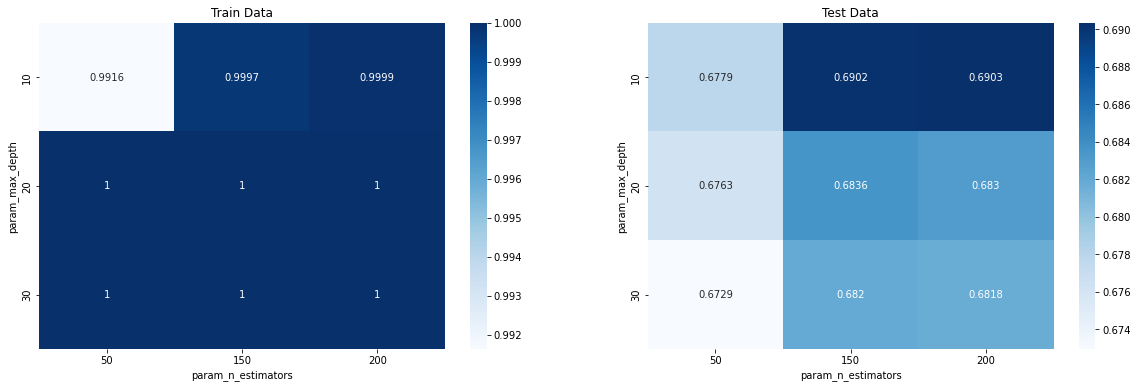

In [88]:
max_auc_scores = results_from_gridsearchcv_s1.groupby(['param_max_depth', 'param_n_estimators']).max()

max_auc_scores = max_auc_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(max_auc_scores.mean_train_score, annot = True, fmt='.4g', cmap="Blues", ax=ax[0])
sns.heatmap(max_auc_scores.mean_test_score, annot = True, fmt='.4g', cmap="Blues", ax=ax[1])

ax[0].set_title('Train Data')
ax[1].set_title('Test Data')
plt.show()

TESTING the performance of the model on test data, plotting ROC Curves

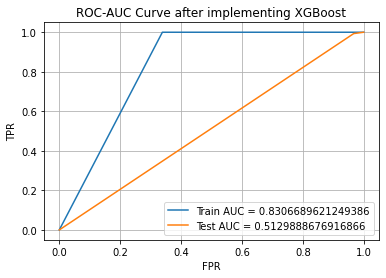

In [89]:
xgb_clf_bh_s1 = XGBClassifier(max_depth = 10, n_estimators= 200)
xgb_clf_bh_s1.fit(X_train_s1_merged, y_train)   

y_train_predicted_s1 = xgb_clf_bh_s1.predict(X_train_s1_merged)
y_test_predicted_s1 = xgb_clf_bh_s1.predict(X_test_s1_merged)

s1_train_fpr, s1_train_tpr, s1_train_threshold = roc_curve(y_train, y_train_predicted_s1)
s1_test_fpr, s1_test_tpr, s1_test_threshold = roc_curve(y_test, y_test_predicted_s1)

#Accuracy_of_Model_s1 = accuracy_score(y_test,y_test_predicted_s1)
#print("Accuracy",Accuracy_of_Model_s1)

# calculate scores
train_auc_s1 = str(auc(s1_train_fpr, s1_train_tpr))
test_auc_s1 = str(auc(s1_test_fpr, s1_test_tpr))    

                                            
plt.plot(s1_train_fpr, s1_train_tpr, label="Train AUC = "+train_auc_s1)    
plt.plot(s1_test_fpr, s1_test_tpr, label="Test AUC = "+test_auc_s1)


plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC-AUC Curve after implementing XGBoost')
plt.show()

In [90]:
def predict_y_vector_from_threshold(probability, threshold, fpr, tpr):
  
    optimal_threshold = threshold[np.argmax(tpr * (1-fpr))]  

    predicted_y_vector = []
    for i in probability:
        if i >= optimal_threshold:
            predicted_y_vector.append(1)
        else:
            predicted_y_vector.append(0)

    return predicted_y_vector

In [91]:
confusion_matrix_s1_train = confusion_matrix(y_train, predict_y_vector_from_threshold(y_train_predicted_s1, s1_train_threshold, s1_train_fpr, s1_train_tpr ) )
confusion_matrix_s1_test = confusion_matrix(y_test, predict_y_vector_from_threshold(y_test_predicted_s1, s1_test_threshold, s1_test_fpr, s1_test_tpr ) )

print('confusion_matrix_s1_train ', confusion_matrix_s1_train)
print("*"*50)
print('confusion_matrix_s1_test ', confusion_matrix_s1_test)



confusion_matrix_s1_train  [[ 2689  1377]
 [    0 22699]]
**************************************************
confusion_matrix_s1_test  [[  55 1626]
 [  66 9725]]


In [92]:
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

In [93]:
label_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), confusion_matrix_s1_train.flatten())])).reshape(2,2)
label_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),confusion_matrix_s1_test.flatten())])).reshape(2,2)

Confusion matrix with predicted and original labels of train data points

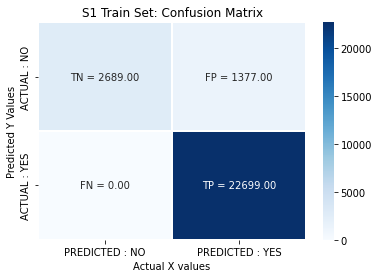

In [94]:
# Heatmap for Confusion Matrix: Train and SET 1
sns.heatmap(confusion_matrix_s1_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = label_train, fmt = '',cmap="Blues")

plt.title('S1 Train Set: Confusion Matrix')
plt.xlabel('Actual X values')
plt.ylabel('Predicted Y Values')
plt.show()

Confusion matrix with predicted and original labels of test data points

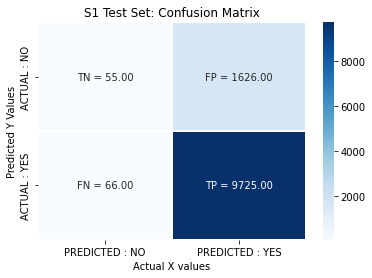

In [95]:
sns.heatmap(confusion_matrix_s1_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = label_test, fmt = '',cmap="Blues")


plt.title('S1 Test Set: Confusion Matrix')
plt.xlabel('Actual X values')
plt.ylabel('Predicted Y Values')
plt.show()

**Train XGBoost model on set-2**

In [96]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

xgb_clf_s2 = XGBClassifier()

params = {
"max_depth":[10,20,30],
'n_estimators': [50,150,200]
}

grid_search_s2 = GridSearchCV(xgb_clf_s2, params, cv=3, scoring='roc_auc',verbose = 2,return_train_score=True)

grid_search_s2.fit(X_train_s2_merged, y_train) 

best_params_gridsearch_xgb_s2 = grid_search_s2.best_params_ 
best_score_s2 = grid_search_s2.best_score_ 

print("Best Params from GridSearchCV with XGB for Set s2 ", best_params_gridsearch_xgb_s2)
print("Best score",best_score_s2)   

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=10, n_estimators=50; total time= 2.3min
[CV] END ......................max_depth=10, n_estimators=50; total time= 2.3min
[CV] END ......................max_depth=10, n_estimators=50; total time= 2.3min
[CV] END .....................max_depth=10, n_estimators=150; total time= 7.2min
[CV] END .....................max_depth=10, n_estimators=150; total time= 7.3min
[CV] END .....................max_depth=10, n_estimators=150; total time= 7.2min
[CV] END .....................max_depth=10, n_estimators=200; total time= 9.4min
[CV] END .....................max_depth=10, n_estimators=200; total time= 9.3min
[CV] END .....................max_depth=10, n_estimators=200; total time= 9.2min
[CV] END ......................max_depth=20, n_estimators=50; total time= 3.7min
[CV] END ......................max_depth=20, n_estimators=50; total time= 3.7min
[CV] END ......................max_depth=20, n_es

In [97]:
results_from_gridsearchcv_s2 = pd.DataFrame(grid_search_s2.cv_results_)
results_from_gridsearchcv_s2.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,138.767930,0.419758,1.272412,0.014535,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.675657,0.660822,0.667141,0.667874,0.006078,7,1.0,1.0,1.0,1.0,0.0
1,432.773593,4.359543,1.379927,0.025291,10,150,"{'max_depth': 10, 'n_estimators': 150}",0.684184,0.670804,0.677210,0.677399,0.005464,2,1.0,1.0,1.0,1.0,0.0


Heat-Map for Set-2

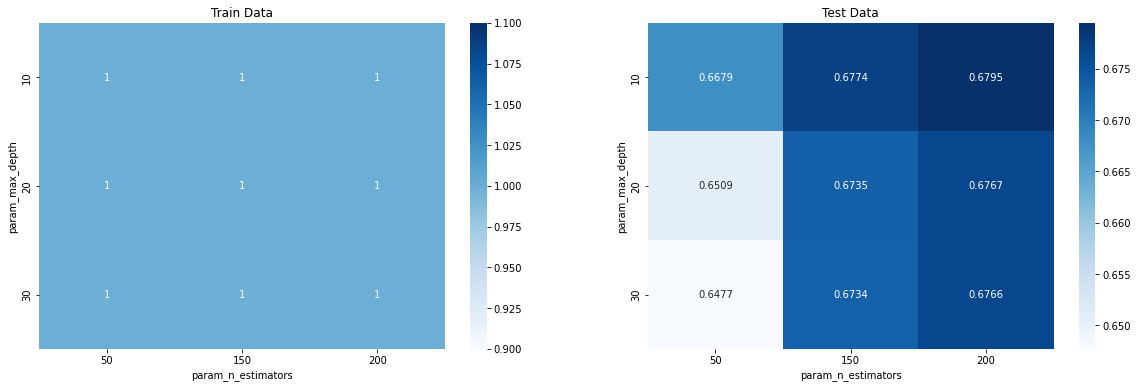

In [98]:
max_auc_scores = results_from_gridsearchcv_s2.groupby(['param_max_depth', 'param_n_estimators']).max()

max_auc_scores = max_auc_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(max_auc_scores.mean_train_score, annot = True, fmt='.4g', cmap="Blues", ax=ax[0])
sns.heatmap(max_auc_scores.mean_test_score, annot = True, fmt='.4g', cmap="Blues", ax=ax[1])

ax[0].set_title('Train Data')
ax[1].set_title('Test Data')
plt.show()

ROC curve - After finding the best hyper parameter, training our model with it, and finding the AUC on test data and plot the ROC curve on both train and test.

In [1]:
xgb_clf_bh_s2 = XGBClassifier(max_depth = 10, n_estimators= 200)
xgb_clf_bh_s2.fit(X_train_s2_merged, y_train)

y_train_predicted_s2 = xgb_clf_bh_s2.predict(X_train_s2_merged)
y_test_predicted_s2 = xgb_clf_bh_s2.predict(X_test_s2_merged)

s2_train_fpr, s2_train_tpr, s2_train_threshold = roc_curve(y_train, y_train_predicted_s2)
s2_test_fpr, s2_test_tpr, s2_test_threshold = roc_curve(y_test, y_test_predicted_s2)

#Accuracy_of_Model_s2 = accuracy_score(y_test,y_test_predicted_s2)
#print("Accuracy",Accuracy_of_Model_s2)

# calculate scores
train_auc_s2 = str(auc(s2_train_fpr, s2_train_tpr))
test_auc_s2 = str(auc(s2_test_fpr, s2_test_tpr))


plt.plot(s2_train_fpr, s2_train_tpr, label="Train AUC = "+train_auc_s2)
plt.plot(s2_test_fpr, s2_test_tpr, label="Test AUC = "+test_auc_s2)


plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC-AUC Curve after implementing XGBoost')
plt.show()

NameError: ignored

In [ ]:
confusion_matrix_s2_train = confusion_matrix(y_train, predict_y_vector_from_threshold(y_train_predicted_s2, s2_train_threshold, s2_train_fpr, s2_train_tpr ) )
confusion_matrix_s2_test = confusion_matrix(y_test, predict_y_vector_from_threshold(y_test_predicted_s2, s2_test_threshold, s2_test_fpr, s2_test_tpr ) )

print('confusion_matrix_s2_train ', confusion_matrix_s2_train)
print("*"*50)
print('confusion_matrix_s2_test ', confusion_matrix_s2_test)

confusion_matrix_s2_train  [[  186 11371]
 [   56 64860]]
**************************************************
confusion_matrix_s2_test  [[   44  4941]
 [   48 27742]]


In [ ]:
label_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), confusion_matrix_s2_train.flatten())])).reshape(2,2)
label_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),confusion_matrix_s2_test.flatten())])).reshape(2,2)

**Confusion matrix for train data**

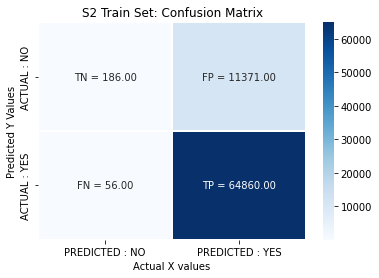

In [ ]:
# Heatmap for Confusion Matrix: Train and SET 1
sns.heatmap(confusion_matrix_s2_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = label_train, fmt = '',cmap="Blues")

plt.title('S2 Train Set: Confusion Matrix')
plt.xlabel('Actual X values')
plt.ylabel('Predicted Y Values')
plt.show()

**Confusion Matrix for test data**

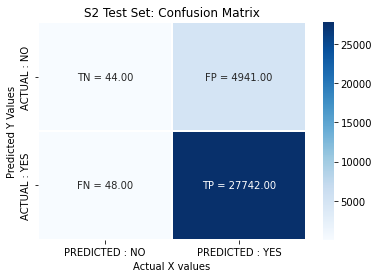

In [ ]:
sns.heatmap(confusion_matrix_s2_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = label_test, fmt = '',cmap="Blues")


plt.title('S2 Test Set: Confusion Matrix')
plt.xlabel('Actual X values')
plt.ylabel('Predicted Y Values')
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [ ]:
from sklearn.metrics import accuracy_score


Accuracy_of_Model_s2 = accuracy_score(y_test,y_test_predicted_s2)
pretty_table = pd.DataFrame(columns = ['Model','Hyper-parameter_max_depth','Hyper-parameter_n_estimators','Train-AUC','Test-AUC'])
pretty_table['Model'] = ["XGB-TFIDF","XGB-TFIDF-W2V"]
pretty_table['Hyper-parameter_max_depth'] = [10,10]
pretty_table['Hyper-parameter_n_estimators'] = [200,200]
pretty_table['Train-AUC'] = [0.7639248146232109,train_auc_s2]
pretty_table['Test-AUC'] = [0.5137137173711016,test_auc_s2]
pretty_table

,Model,Hyper-parameter_learning_rate,Hyper-parameter_n_estimators,Train-AUC,Test-AUC,Accuracy
0,XGB-TFIDF,0.2,75,0.5038185242077444,0.5017464772872052,0.847933
1,XGB-TFIDF-W2V,0.2,75,0.5076157444016962,0.5035496197119607,0.847780
